<a href="https://colab.research.google.com/github/TheViriato/MonitoringGreenhousesPortugal/blob/main/RobustRandomForestsTrimestral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing TensorFlow Decision Forests

Install TF-DF by running the following cell.

In [ ]:
!pip install tensorflow_decision_forests

Install [Wurlitzer](https://pypi.org/project/wurlitzer/) to display
the detailed training logs. This is only needed in colabs.

In [ ]:
!pip install wurlitzer

## Importing libraries

In [ ]:
import tensorflow_decision_forests as tfdf

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import math

try:
  from wurlitzer import sys_pipes
except:
  from colabtools.googlelog import CaptureLog as sys_pipes

from IPython.core.magic import register_line_magic
from IPython.display import Javascript

In [ ]:
# Your Earth Engine username.  This is used to import a classified image
# into your Earth Engine assets folder.
USER_NAME = 'pedro54cardoso'
OUTPUT_BUCKET = 'pedro_bucks'

#Filtered Feature Set
BANDS = [
  'B2_pri','B3_pri','B4_pri','B8_pri','rpg_pri','ndvi_pri','alb_pri',
  'B2_seg','B3_seg','B8_seg','rpg_seg','ndvi_seg','alb_seg',
  'B2_ter','B4_ter','B8_ter','rpg_ter','ndvi_ter','alb_ter',
  'B2_may','B3_may','B4_may','B8_may','rpg_may','ndvi_may',
  'B3_jun','B4_jun','B8_jun','rpg_jun','ndvi_jun','alb_jun',
  'B2_jul','B3_jul','B4_jul','B8_jul','rpg_jul','ndvi_jul','alb_jul',
  'B2_aug','B4_aug','B8_aug','rpg_aug','ndvi_aug','alb_aug',
  'B2_sep','B3_sep','B4_sep','B8_sep','rpg_sep','ndvi_sep','alb_sep',
  'B2_oct','B3_oct','B4_oct','B8_oct','rpg_oct','ndvi_oct','alb_oct',
]

'''
#Original Feature Set
BANDS = [
  'B2_pri','B3_pri','B4_pri','B8_pri','rpg_pri','ndvi_pri','alb_pri',
  'B2_seg','B3_seg','B4_seg','B8_seg','rpg_seg','ndvi_seg','alb_seg',
  'B2_ter','B3_ter','B4_ter','B8_ter','rpg_ter','ndvi_ter','alb_ter',
  'B2_may','B3_may','B4_may','B8_may','rpg_may','ndvi_may','alb_may',
  'B2_jun','B3_jun','B4_jun','B8_jun','rpg_jun','ndvi_jun','alb_jun',
  'B2_jul','B3_jul','B4_jul','B8_jul','rpg_jul','ndvi_jul','alb_jul',
  'B2_aug','B3_aug','B4_aug','B8_aug','rpg_aug','ndvi_aug','alb_aug',
  'B2_sep','B3_sep','B4_sep','B8_sep','rpg_sep','ndvi_sep','alb_sep',
  'B2_oct','B3_oct','B4_oct','B8_oct','rpg_oct','ndvi_oct','alb_oct',
]
'''

LABEL = 'Class'
# Number of label values, i.e. number of classes in the classification.
N_CLASSES = 4

# These names are used to specify properties in the export of
# training/testing data and to define the mapping between names and data
# when reading into TensorFlow datasets.
FEATURE_NAMES = list(BANDS)
FEATURE_NAMES.append(LABEL)

Mount Google Drive

In [ ]:
from google.colab import drive

drive._mount('/content/drive')

#If the current cell didn't work, uncomment the following line
#drive.mount("/content/drive", force_remount=True)

Authenticate your Google account

In [ ]:
# This only needs to be done once per notebook
!pip install -U PyDrive
#import authentification libraries
from google.colab import auth
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from oauth2client.client import GoogleCredentials
#Authenticate for connection
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
#@title Load training/testing data from Earth Engine exports
import tensorboard as tb

# Specify the training file exported from EE.
# If you wish to use your own data, then
# replace the file ID, below, with your own file.
trainFileId = '1V0joE0_OP5No0tjNKrOQ2x_rHT0ZBsPJ'
trainDownload = drive.CreateFile({'id': trainFileId})
# Create a local file of the specified name.
tfrTrainFile = 'training.tfrecord.gz'
trainDownload.GetContentFile(tfrTrainFile)

# Specify the test file.
# If you wish to use your own data, then
# replace the file ID, below, with your own file.

#Alentejo Litoral 2020
testFileId = '1UDiK8N8PiH47Bgp8RnMw89yHHNKk3ABz'
testDownload = drive.CreateFile({'id': testFileId})
# Creates a local file of the specified name.
tfrTestFile = 'testing.tfrecord.gz'
testDownload.GetContentFile(tfrTestFile)

#--------------------------------------------------------
#Oeste
testFileId2 = '1FblNGSqPk8NVaYfOdr5JM2rIbdxc_6wZ'
testDownload2 = drive.CreateFile({'id': testFileId2})
# Creates a local file of the specified name.
tfrTestFile2 = 'testing2.tfrecord.gz'
testDownload2.GetContentFile(tfrTestFile2)

#--------------------------------------------------------
#Alentejo Litoral 2021
testFileId3 = '1Dr-GgMZ1TPVe8WmTS2QXBiaz4OlGfeQd'
testDownload3 = drive.CreateFile({'id': testFileId3})
# Creates a local file of the specified name.
tfrTestFile3 = 'testing3.tfrecord.gz'
testDownload3.GetContentFile(tfrTestFile3)

#--------------------------------------------------------
#Alentejo Litoral 2019
testFileId4 = '1Dlj7JVvXlVqt4ZvVKMkwwNssmySB-I1q'
testDownload4 = drive.CreateFile({'id': testFileId4})
# Creates a local file of the specified name.
tfrTestFile4 = 'testing4.tfrecord.gz'
testDownload4.GetContentFile(tfrTestFile4)

#--------------------------------------------------------
#Agricultural fields in Alentejo Litoral
testFileId5 = '19dHoMY1OOAZl9BoQql_iUzUdeVKTKhtc'
testDownload5 = drive.CreateFile({'id': testFileId5})
# Creates a local file of the specified name.
tfrTestFile5 = 'testing5.tfrecord.gz'
testDownload5.GetContentFile(tfrTestFile5)

#--------------------------------------------------------
#Solar panels in the Algarve
testFileId6 = '1FWQMZeMUhCxV_xdllnJCofE1Eos-mW1T'
testDownload6 = drive.CreateFile({'id': testFileId6})
# Creates a local file of the specified name.
tfrTestFile6 = 'testing6.tfrecord.gz'
testDownload6.GetContentFile(tfrTestFile6)

print('Successfully downloaded training file?')

!ls

# Read into a tf.data.Dataset

In [ ]:
# Create a dataset from the TFRecord file in Cloud Storage.
train_dataset = tf.data.TFRecordDataset(tfrTrainFile, compression_type='GZIP')
# Print the first record to check.
print(iter(train_dataset).next())

## Define the structure of your data

For parsing the exported TFRecord files, `featuresDict` is a mapping between feature names (recall that `featureNames` contains the band and label names) and `float32` [`tf.io.FixedLenFeature`](https://www.tensorflow.org/api_docs/python/tf/io/FixedLenFeature) objects.  This mapping is necessary for telling TensorFlow how to read data in a TFRecord file into tensors.  Specifically, **all numeric data exported from Earth Engine is exported as `float32`**.

(Note: *features* in the TensorFlow context (i.e. [`tf.train.Feature`](https://www.tensorflow.org/api_docs/python/tf/train/Feature)) are not to be confused with Earth Engine features (i.e. [`ee.Feature`](https://developers.google.com/earth-engine/api_docs#eefeature)), where the former is a protocol message type for serialized data input to the model and the latter is a geometry-based geographic data structure.)

In [ ]:
# List of fixed-length features, all of which are float32.
columns = [
  tf.io.FixedLenFeature(shape=[1], dtype=tf.float32) for k in FEATURE_NAMES
]

# Dictionary with names as keys, features as values.
features_dict = dict(zip(FEATURE_NAMES, columns))

print(features_dict)

## Parse the dataset

Now we need to make a parsing function for the data in the TFRecord files.  The data comes in flattened 2D arrays per record and we want to use the first part of the array for input to the model and the last element of the array as the class label.  The parsing function reads data from a serialized [`Example` proto](https://www.tensorflow.org/api_docs/python/tf/train/Example) into a dictionary in which the keys are the feature names and the values are the tensors storing the value of the features for that example.  ([These TensorFlow docs](https://www.tensorflow.org/tutorials/load_data/tfrecord) explain more about reading `Example` protos from TFRecord files).

In [ ]:
def parse_tfrecord(example_proto):
  """The parsing function.

  Read a serialized example into the structure defined by featuresDict.

  Args:
    example_proto: a serialized Example.

  Returns:
    A tuple of the predictors dictionary and the label, cast to an `int32`.
  """
  parsed_features = tf.io.parse_single_example(example_proto, features_dict)
  labels = parsed_features.pop(LABEL)
  return parsed_features, tf.cast(labels, tf.int32)

# Map the function over the dataset.
parsed_dataset = train_dataset.map(parse_tfrecord, num_parallel_calls=5)

# Print the first parsed record to check.
print(iter(parsed_dataset).next())

# Train the classifier

In [ ]:
input_dataset = parsed_dataset.batch(1)

#If you wish to measure the variable importance, use the compute_oob_variable_importances=True parameter
#Removing the parameter will make the training process faster
#Other parameters can be added, for example 'max_depth = 10'
model = tfdf.keras.RandomForestModel(compute_oob_variable_importances=True)

model.compile(metrics=["accuracy"])

model.fit(input_dataset)

#The summary will print information related to the classifier and its variables
print(model.summary())

# Visualization of tree behaviour

In [ ]:
#It's possible to analyze the behaviour of a specific tree of the model  
#tree_idx is the number of the selected tree 
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0, max_depth=4)

# Inspector of model properties

In [ ]:
inspector = model.make_inspector()

print("Model type:", inspector.model_type())
print("Number of trees:", inspector.num_trees())
print("Objective:", inspector.objective())
print("Input features:", inspector.features())
print("Evaluation:", inspector.evaluation())
print("Labels:", inspector.label())

#All existent properties name can be visualize with the following line
#[field for field in dir(inspector) if not field.startswith("_")]

# Testing


In [ ]:
print("Alentejo 2020")
test_dataset = (
  tf.data.TFRecordDataset(tfrTestFile, compression_type='GZIP')
    .map(parse_tfrecord, num_parallel_calls=5)
    .batch(1))

evaluation = model.evaluate(test_dataset, return_dict=True)
print()


for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")
#---------------------------------------------------------------
print("Oeste 2020")
test_dataset2 = (
  tf.data.TFRecordDataset(tfrTestFile2, compression_type='GZIP')
    .map(parse_tfrecord, num_parallel_calls=5)
    .batch(1))

evaluation2 = model.evaluate(test_dataset2, return_dict=True)
print()


for name, value in evaluation2.items():
  print(f"{name}: {value:.4f}")

#---------------------------------------------------------------
print("Alentejo 2021")
test_dataset3 = (
  tf.data.TFRecordDataset(tfrTestFile3, compression_type='GZIP')
    .map(parse_tfrecord, num_parallel_calls=5)
    .batch(1))

evaluation3 = model.evaluate(test_dataset3, return_dict=True)
print()


for name, value in evaluation3.items():
  print(f"{name}: {value:.4f}")
#---------------------------------------------------------------
print("Alentejo 2019")
test_dataset4 = (
  tf.data.TFRecordDataset(tfrTestFile4, compression_type='GZIP')
    .map(parse_tfrecord, num_parallel_calls=5)
    .batch(1))

evaluation4 = model.evaluate(test_dataset4, return_dict=True)
print()


for name, value in evaluation4.items():
  print(f"{name}: {value:.4f}")
#---------------------------------------------------------------
print("Agricultural fields in Alentejo Litoral")
test_dataset5 = (
  tf.data.TFRecordDataset(tfrTestFile5, compression_type='GZIP')
    .map(parse_tfrecord, num_parallel_calls=5)
    .batch(1))

evaluation5 = model.evaluate(test_dataset5, return_dict=True)
print()


for name, value in evaluation5.items():
  print(f"{name}: {value:.4f}")
#---------------------------------------------------------------
print("Solar panels in Algarve")
test_dataset6 = (
  tf.data.TFRecordDataset(tfrTestFile6, compression_type='GZIP')
    .map(parse_tfrecord, num_parallel_calls=5)
    .batch(1))

evaluation6 = model.evaluate(test_dataset6, return_dict=True)
print()


for name, value in evaluation6.items():
  print(f"{name}: {value:.4f}")

# List of variables with importance equal or above 0 

In [ ]:
dictio = inspector.variable_importances()['MEAN_DECREASE_IN_ACCURACY']


def removeBands():
  lista = []
  for x in dictio:
    if x[1] <= 0 :
      lista.append(x[0][0])

  BANDS2 = BANDS.copy()
  for x in lista:
    BANDS2.remove(x)

  return BANDS2

removeBands()

Helpful plots

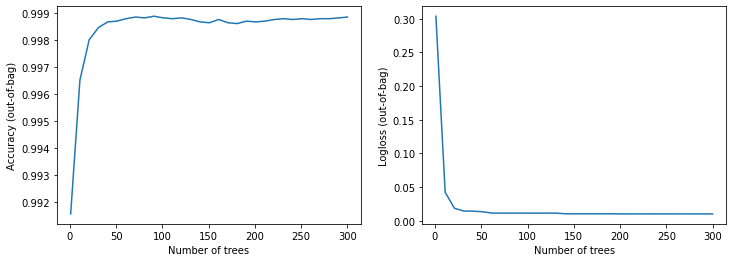

In [ ]:
import matplotlib.pyplot as plt

logs = model.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

plt.show()